In [39]:
# %%
"""
Dedalus script simulating 2D horizontally-periodic Rayleigh-Benard convection.
This script demonstrates solving a 2D Cartesian initial value problem. It can
be ran serially or in parallel, and uses the built-in analysis framework to save
data snapshots to HDF5 files. The `plot_snapshots.py` script can be used to
produce plots from the saved data. It should take about 5 cpu-minutes to run.

For incompressible hydro with two boundaries, we need two tau terms for each the
velocity and buoyancy. Here we choose to use a first-order formulation, putting
one tau term each on auxiliary first-order gradient variables and the others in
the PDE, and lifting them all to the first derivative basis. This formulation puts
a tau term in the divergence constraint, as required for this geometry.

To run and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 rayleigh_benard.py
    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5
"""


# %%
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import copy
import h5py
import numpy as np
import matplotlib
import re

import matplotlib.pyplot as plt
from dedalus.extras import plot_tools

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

import os
from os import listdir

# save_dir= "/scratch/zb2113/DedalusData/4e50.33Q=0.0028"

#if not os.path.exists(save_dir):
#    os.mkdir(save_dir)

# %%
# Parameters
Lx, Lz = 20,1
Nx, Nz = 640, 32
Ra_M = 1e5
D_0 = 0
D_H = 1/3
M_0 = 0
M_H = -1
N_s2=4/3
Qrad=0.0028

Prandtl = 1
dealias = 3/2
stop_sim_time = 200
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# %%
# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
D = dist.Field(name='D', bases=(xbasis,zbasis))
M = dist.Field(name='M', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
Z = dist.Field(name='Z', bases=zbasis)
T = dist.Field(name='T', bases=(xbasis,zbasis))
C = dist.Field(name='C', bases=(xbasis,zbasis))

tau_p = dist.Field(name='tau_p')
tau_B1 = dist.Field(name='tau_B1', bases=xbasis)
tau_B2 = dist.Field(name='tau_B2', bases=xbasis)
tau_D1 = dist.Field(name='tau_D1', bases=xbasis)
tau_D2 = dist.Field(name='tau_D2', bases=xbasis)
tau_M1 = dist.Field(name='tau_M1', bases=xbasis)
tau_M2 = dist.Field(name='tau_M2', bases=xbasis)
tau_u1 = dist.VectorField(coords,name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords,name='tau_u2', bases=xbasis)
tau_u3 = dist.Field(name='tau_u3', bases=xbasis)
tau_u4 = dist.Field(name='tau_u4', bases=xbasis)
tau_T1 = dist.Field(name='tau_t1', bases=xbasis)
tau_T2 = dist.Field(name='tau_t2', bases=xbasis)
tau_C1 = dist.Field(name='tau_c1', bases=xbasis)
tau_C2 = dist.Field(name='tau_c2', bases=xbasis)

# Substitutions    
#Kuo_Bretherton Equilibrium
kappa = (Ra_M * Prandtl/((M_0-M_H)*Lz**3))**(-1/2)
nu = (Ra_M / (Prandtl*(M_0-M_H)*Lz**3))**(-1/2)
print('kappa',kappa)
print('nu',nu)



x,z = dist.local_grids(xbasis,zbasis)

Z['g']=z
# Z.change_scales(3/2)


ex,ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

B_op = (np.absolute(D - M - N_s2*Z)+ M + D - N_s2*Z)/2
lq = B_op/2 + np.absolute(B_op)



Max = lambda A,B: (abs(A-N_s2*Z-B)+A-N_s2*Z+B)/2
eva = lambda A: A.evaluate()

dz= lambda A: d3.Differentiate(A, coords['z'])
dx= lambda A: d3.Differentiate(A, coords['x'])


ux=u@ex
uz=u@ez
dxux=dx(ux)
dzux=dz(ux)
dxuz=dx(uz)
dzuz=dz(uz)

grad_u = d3.grad(u) + ez* lift(tau_u1) # First-order reduction
grad_ux = grad_u@ex # First-order reduction
grad_uz = grad_u@ez # First-order reduction
grad_M = d3.grad(M) + ez*lift(tau_M1) # First-order reduction
grad_D = d3.grad(D) + ez*lift(tau_D1) # First-order reduction
grad_T = d3.grad(T) + ez*lift(tau_T1)
grad_C = d3.grad(C) + ez*lift(tau_C1)

# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, M, D, u, T, C, tau_p, tau_M1, tau_M2, tau_D1, tau_D2, tau_u1, tau_u2, tau_T1, tau_T2, tau_C1, tau_C2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p= 0")
problem.add_equation("dt(M) - kappa*div(grad_M) + lift(tau_M2) = - u@grad(M)-Qrad/2*np.sin(np.pi*Z/Lz)")
problem.add_equation("dt(D) - kappa*div(grad_D) + lift(tau_D2) = - u@grad(D)-Qrad*np.sin(np.pi*Z/Lz)")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p)  + lift(tau_u2) = - u@grad(u)+ B_op*ez")
problem.add_equation("dt(T) - kappa*div(grad_T) + lift(tau_T2) = - u@grad(T)")
problem.add_equation("dt(C) - kappa*div(grad_C) + lift(tau_C2) = - u@grad(C)+1")
problem.add_equation("u(z=0) = 0")
problem.add_equation("uz(z=Lz) = 0")
problem.add_equation("dz(ux)(z=Lz)=0")
problem.add_equation("M(z=0) = M_0")
problem.add_equation("D(z=0) = D_0")
problem.add_equation("M(z=Lz) = M_H")
problem.add_equation("D(z=Lz) = D_H")
problem.add_equation("dz(T)(z=0) = 0")
problem.add_equation("dz(T)(z=Lz) = 0")
problem.add_equation("C(z=0) = 0")
problem.add_equation("dz(C)(z=Lz) = 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

# %%
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time


# %%
# Initial condition
D.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
D['g'] *= z * (Lz - z) # Damp noise at walls
print(D['g'].shape)
print((z * (Lz - z)).shape)
D['g'] += (D_H-D_0)*z # Add linear background
M.fill_random('g', seed=28, distribution='normal', scale=1e-3) # Random noise
M['g'] *= z * (Lz - z) # Damp noise at walls
M['g'] += (M_H-M_0)*z # Add linear background
T.fill_random('g', seed=42, distribution='normal', scale=1) # Random 

# %%
# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots',sim_dt=0.25, max_writes=1)
snapshots.add_tasks(solver.state,layout='g')
snapshots.add_task(d3.Average(dz(D),coords['x']),name='Dry derivative')
snapshots.add_task(d3.Average(dz(M),coords['x']),name='Moist derivative')
snapshots.add_task(-Lz*(2*dz(M)(z=0)-dz(D)(z=0))/(2*(M_0-M_H)-(D_0-D_H)),name='Nusselt Number')
snapshots.add_task(d3.Average(M, coords['x']), name='horizontal avg M')
snapshots.add_task(d3.Average(D, coords['x']), name='horizontal avg D')
snapshots.add_task(d3.Average(B_op, coords['x']), name='horizontal avg B')
snapshots.add_task(d3.Average(lq, coords['x']), name='horizontal avg liquid')
snapshots.add_task(d3.Average(T, coords['x']), name='horizontal avg T')
snapshots.add_task(d3.Average(C, coords['x']), name='horizontal avg C')
snapshots.add_task(d3.Integrate(0.5*u@u,coords),name='total KE')
snapshots.add_task(uz, name='uz')



kappa 0.0031622776601683794
nu 0.0031622776601683794
2024-06-11 20:23:01,402 subsystems 0/1 INFO :: Building subproblem matrices 1/320 (~0%) Elapsed: 0s, Remaining: 37s, Rate: 8.6e+00/s
2024-06-11 20:23:03,077 subsystems 0/1 INFO :: Building subproblem matrices 32/320 (~10%) Elapsed: 2s, Remaining: 16s, Rate: 1.8e+01/s
2024-06-11 20:23:04,717 subsystems 0/1 INFO :: Building subproblem matrices 64/320 (~20%) Elapsed: 3s, Remaining: 14s, Rate: 1.9e+01/s
2024-06-11 20:23:06,872 subsystems 0/1 INFO :: Building subproblem matrices 96/320 (~30%) Elapsed: 6s, Remaining: 13s, Rate: 1.7e+01/s
2024-06-11 20:23:08,640 subsystems 0/1 INFO :: Building subproblem matrices 128/320 (~40%) Elapsed: 7s, Remaining: 11s, Rate: 1.7e+01/s
2024-06-11 20:23:10,459 subsystems 0/1 INFO :: Building subproblem matrices 160/320 (~50%) Elapsed: 9s, Remaining: 9s, Rate: 1.7e+01/s
2024-06-11 20:23:11,338 subsystems 0/1 INFO :: Building subproblem matrices 176/320 (~55%) Elapsed: 10s, Remaining: 8s, Rate: 1.8e+01/s
20

In [6]:

# Parameters
num_particles = 1000
delta_t = 0.01
D = 0.001  # Diffusivity
bottom_boundary_y = 0.0  # y-coordinate of the bottom boundary

# Initialize particle positions and clock tracers
particles = np.random.rand(num_particles, 2)  # Assuming a 2D domain
particles[:, 1] *= 1  # Adjust to fit within the domain height
clock_tracers = np.zeros(num_particles)  # Initialize clock tracers to zero

from scipy.interpolate import RegularGridInterpolator

def interpolate_velocity(ux, uz, x, z, particles):
    # Create interpolators for u and v
    interp_u = RegularGridInterpolator((x, z), ux['g'].T)
    interp_v = RegularGridInterpolator((x, z), uz['g'].T)
    
    # Interpolate velocities at particle positions
    particle_u = interp_u(particles)
    particle_v = interp_v(particles)
    
    return particle_u, particle_v




# %%
# CFL
CFL = d3.CFL(solver, initial_dt=0.1, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.1, min_change=0, max_dt=max_timestep)
CFL.add_velocity(u)

# %%
# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')


# %%
# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        # Interpolate fluid velocity at particle positions
        particle_u, particle_v = interpolate_velocity(ux, uz, x, z, particles)

        # Update particle positions using Euler-Maruyama method
        eta = np.random.normal(0, np.sqrt(delta_t), size=particles.shape)
        particles[:, 0] += particle_u * delta_t + np.sqrt(2 * D * delta_t) * eta[:, 0]
        particles[:, 1] += particle_v * delta_t + np.sqrt(2 * D * delta_t) * eta[:, 1]

        # Check if particles have touched the bottom boundary
        for p in range(num_particles):
            if particles[p, 1] <= bottom_boundary_y:
                clock_tracers[p] = 0  # Reset clock tracer to zero
            else:
                clock_tracers[p] += delta_t  # Increment clock tracer
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Analyze particle positions and clock tracers
plt.scatter(particles[:, 0], particles[:, 1], c=clock_tracers, cmap='viridis')
plt.colorbar(label='Clock Tracer')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Particle Positions and Clock Tracers')
plt.show()


2024-06-11 18:14:06,198 __main__ 0/1 INFO :: Starting main loop
2024-06-11 18:14:06,361 __main__ 0/1 ERROR :: Exception raised, triggering end of main loop.
2024-06-11 18:14:06,361 solvers 0/1 INFO :: Final iteration: 2
2024-06-11 18:14:06,362 solvers 0/1 INFO :: Final sim time: 0.2
2024-06-11 18:14:06,362 solvers 0/1 INFO :: Setup time (init - iter 0): 46.52 sec
2024-06-11 18:14:06,362 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.


TypeError: 'DotProduct' object is not subscriptable

In [40]:
z_min = 0
z_max = 0.3
# %%
# CFL

CFL = d3.CFL(solver, initial_dt=0.1, cadence=1, safety=0.3, threshold=0.05,
             max_change=1.1, min_change=0.25, max_dt=max_timestep)
CFL.add_velocity(u)


# %%
# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')

Z.change_scales(3/2)
z=Z['g']

# %%
# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep) 
        # # Reset
        # #max(z-z_min,0)/(z-z_,in)
        # abs1=(z-z_min)/2+abs(z-z_min)/2
        # lowcond=abs1/(z-z_min)
        # #Similarly
        # abs2=(z_max-z)/2+abs(z_max-z)/2
        # highcond=abs2/(z_max-z)
        # # print(highcond.shape)
        # # print(M['g'].shape)
        # C['g'] *= lowcond*highcond
        
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re ))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()



2024-06-11 20:24:02,451 __main__ 0/1 INFO :: Starting main loop


2024-06-11 20:24:03,264 __main__ 0/1 INFO :: Iteration=1, Time=1.000000e-01, dt=1.000000e-01, max(Re)=0.000000
2024-06-11 20:24:05,066 __main__ 0/1 INFO :: Iteration=11, Time=1.278000e+00, dt=1.210000e-01, max(Re)=0.029837
2024-06-11 20:24:06,266 __main__ 0/1 INFO :: Iteration=21, Time=2.488000e+00, dt=1.210000e-01, max(Re)=0.057536
2024-06-11 20:24:07,452 __main__ 0/1 INFO :: Iteration=31, Time=3.698000e+00, dt=1.210000e-01, max(Re)=0.118333
2024-06-11 20:24:08,638 __main__ 0/1 INFO :: Iteration=41, Time=4.908000e+00, dt=1.210000e-01, max(Re)=0.252610
2024-06-11 20:24:09,819 __main__ 0/1 INFO :: Iteration=51, Time=6.118000e+00, dt=1.210000e-01, max(Re)=0.550229
2024-06-11 20:24:11,033 __main__ 0/1 INFO :: Iteration=61, Time=7.328000e+00, dt=1.210000e-01, max(Re)=1.216502
2024-06-11 20:24:12,140 __main__ 0/1 INFO :: Iteration=71, Time=8.538000e+00, dt=1.210000e-01, max(Re)=2.719970
2024-06-11 20:24:13,321 __main__ 0/1 INFO :: Iteration=81, Time=9.748000e+00, dt=1.210000e-01, max(Re)=6.

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
2024-06-11 21:46:01,814 matplotlib.text 0/1 WARNING :: posx and posy should be finite values
2024-06-11 21:46:01,854 matplotlib.text 0/1 WARNING :: posx and posy should be finite values


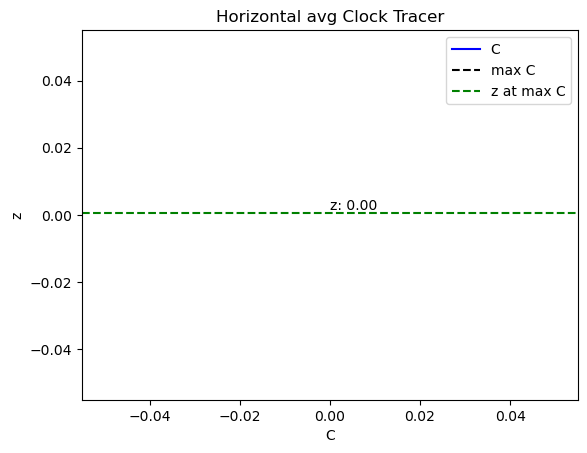

<Figure size 640x480 with 0 Axes>

In [52]:

import matplotlib
import re


import os
from os import listdir
x,z = dist.local_grids(xbasis,zbasis)
#Plot horizontal avg C
folder_dir = "/Users/bobby/Documents/GitHub/Research-Dedalus/snapshots"

file_paths = [os.path.join(folder_dir, file) for file in os.listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
# Sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
# Read the last file in the file path
file = file_paths[-1]
with h5py.File(file, mode='r') as file:
    avgC = file['tasks']['horizontal avg C'][-1, 0, :]
    print(avgC)
    avgC = np.array(avgC)
    z = z.reshape(-1)
    # Plot the horizontal avg C
    plt.plot(avgC, z, color='blue', label='C')
    
    maxC = max(avgC)
    plt.axvline(x=maxC, color='black', linestyle='--', label='max C')
    
    # Find the z value corresponding to max C and add a horizontal line
    maxC_index = np.argmax(avgC)
    z_maxC = z[maxC_index]
    plt.axhline(y=z_maxC, color='green', linestyle='--', label='z at max C')
    
    # Annotate the max C and its corresponding z value
    plt.text(maxC, 0, f'max C: {maxC:.2f}', horizontalalignment='right', verticalalignment='bottom')
    plt.text(0, z_maxC, f'z: {z_maxC:.2f}', horizontalalignment='left', verticalalignment='bottom')
    
    plt.xlabel('C')
    plt.ylabel('z')
    plt.title('Horizontal avg Clock Tracer')
    plt.legend()
    # plt.savefig(plot_dir + '/Horizontal avg C.png', dpi=200, bbox_inches='tight')
    plt.show()
    plt.clf()